In [1]:
import numpy as np
import os, sys, re
from math import *
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tekal import *
from uitintegratie import *
import pandas as pd
import dill

import numpy.ma as ma
import fit_beta as fb
from gumplot import *
import scipy.special as scs
import bisect
from IPython.lib.deepreload import reload as dreload
import inspect

<h2>Stappen om tot de werklijn te komen mét gecombineerde onzekerheid</h2>
<ul>
    <li> Er is uitgegaan van de afvoer jaarmaxima berekend door HBV op basis van de <a href="#ref2021">referentie simulatie</a> met de neerslaggenerator, uitgedrukt als $\mu_{HBV}$</li>
    <li> De HBV afvoermaxima $\mu_{HBV}$ worden getransformeerd naar Sobek afvoermaxima $\mu_{SBK}$ middels de     regressie         (H.vd Boogaard)</li>
<li> <b>Onzekerheid Meteo + HBV:</b></li>    
    <ul>
        <li> De onzekerheid van deze maxima wordt voorgesteld als een verstoring op $\mu_{HBV}$ met een verdeling $N(0,\sigma_{HBV})$</li>
        <li> Deze onzekerheid is vastgesteld met behulp van een Jackknife analyse (gevoeligheid neerslagdata) en een GLUE analyse (HBV modelonzekerheid)</li>
    </ul>
    <li> <b>Onzekerheid hydraulica:</b></li>    
    <ul>
        <li> Modelstudies zijn uitgevoerd met SOBEK onder variërende hydraulische condities (parameter variaties) voor specifieke cases.</li>
        <li> Per case vormen de vekregen SOBEK resultaten voor verwschillende parametersets een populatie.</li>
        <li> Aan elke populatie zijn de parameters $\alpha, \beta, A, B$ van de 4-parameter Beta verdeling gefit</li>
        <li> Uit de parametersets </li>
        <li> Centreer een beta verdeling om nul, gebaseerd met parameters die een functie zijn van $\mu_{sobek}$</li>
        <li> Sample de gecombineerde verdeling:
            <ul>
                <li> Trek uit de normale verdeling voor de "meteo/jackknife onzekerheid" (!nb: een HBV resultaat)</li>
                <li> Trek uit de bijbehorende beta verdeling</li>
                <li> sommeer</li>
            </ul>
        <li> Fit nieuwe beta parameters </li>
        <li> Bepaal betrouwbaarheids intervallen </li>
    </ul>
</ul>

In [2]:
# Relevante herhaaltijden
Tretlist = [10,100,1000,1250,3000,10000,50000,100000,200000,300000,400000]

<h3>Regressie HBV-to-SOBEK Rijn</h3>
Uit regressie is een relatie bepaald uit de HBV-(piek)afvoeren $Q_h$ en de bijbehorende Sobek (piek)afvoeren $Q_s$ als volgt (Henk vd Boogaard, <tt>regression_2018</tt>):
    $$Q_s\,=\,C\,+\,r_1Q_h\,+\,(r_2-r_1)\sigma_1\log\left(1+\exp\left(\frac{Q_h-\mu_1}{\sigma_1}\right)\right)$$
    $$\phantom{Q_s\,=\,C\,+\,r_1Q_h\,}+\,(r_3-r_2)\,\sigma_2\log\left(1+\exp\left(\frac{Q_h-\mu_2}{\sigma_2}\right)\right)$$    
    $$\phantom{Q_s\,=\,C\,+\,r_1Q_h\,}+\,(r_4-r_3)\,\sigma_3\log\left(1+\exp\left(\frac{Q_h-\mu_3}{\sigma_3}\right)\right)$$
    $$\phantom{Q_s\,=\,C\,+\,r_1Q_h\,}+\,(r_5-r_4)\,\sigma_4\log\left(1+\exp\left(\frac{Q_h-\mu_4}{\sigma_4}\right)\right)$$

In [3]:
import math   # Crucial import !!!
def regression_2018(x, fit_regr=False):
    c      = 342.254390
    r1     = 0.91577902
    mu1    = 14442.2780 #ORIG
    sigma1 = 307.118620
    r2     = 0.32752076
    mu2    = 18573.2200 #ORIG
    sigma2 = 2.71804449E-14
    r3     = 0.53632634 #ORIG
    mu3    = 21904.1250 #ORIG
    sigma3 = 136.807970  
    r4     = 0.21296795
    mu4    = 26177.6500 #ORIG
    sigma4 = 79.5476640
    r5     = 0.00000000
    if fit_regr == True:
        mu1    = 14800.0000
        mu2    = 17750.0000
        r3     = 0.75000000
        mu3    = 20000.0000
    
    x_ = []
    for value in x:
        z1 = (value-mu1)/sigma1
        z2 = (value-mu2)/sigma2
        z3 = (value-mu3)/sigma3
        z4 = (value-mu4)/sigma4
        
        a1 = (r1*value)
        a2 = ((r2-r1)*sigma1*np.log(1+np.exp(z1)))
        try:
            a3 = ((r3-r2)*sigma2*np.log(1+math.exp(z2)))
        except:
            a3 = ((r3-r2)*sigma2*z2)
        a4 = ((r4-r3)*sigma3*np.log(1+np.exp(z3)))
        a5 = ((r5-r4)*sigma4*np.log(1+np.exp(z4)))
        
        y = c + a1 + a2 + a3 + a4 + a5
        x_.append(y)

    return x_

In [4]:
# Lees oude werklijn
column_Tret  = 8
column_Qref  = 9
column_Sigma = 10

with open('./oude_getallen.csv',"r") as fnin:
    sgv_list = []
    mu_list = []
    sigma_list = []
    while True:
        line = fnin.readline()
        if not line:
            break
        if line[0] in '#*':
            continue
        columns = line.strip().split(';')
        Tret = float(columns[column_Tret-1])
        mu_value = float(columns[column_Qref-1])
        sigma_value = float(columns[column_Sigma-1])
        sgv_list.append(-np.log(-np.log(1.-1./Tret)))
        mu_list.append(mu_value)
        sigma_list.append(sigma_value)
nx_old = len(sgv_list)        
np_sgv_old = np.array(sgv_list)        
np_qref_old = np.array(mu_list)
np_sigma_old = np.array(sigma_list)
rijn_old={'sgv':np.array(sgv_list),'mu':np.array(mu_list),'sigma':np.array(sigma_list)}

<H3> Referentie werklijn voor de Rijn (2021)</H3>
<a id="ref2021"/>

In [5]:
# Lees de referentie werklijn voor de Rijn (2021)
with open('optimal_slice_mem6d_Fwet_500K_1951-2015_window61_part001-025_MAX.csv',"r") as fnin:
    qref = []
    minimum = 1000000.
    while True:
        line = fnin.readline()
        if not line:
            break
        syear, sqvalue = line.strip().split(',')
        try:
            year = int(syear)
            qvalue = float(sqvalue)
        except:
            continue
        bisect.insort(qref,qvalue)
nx = len(qref)
np_qref = np.array(qref)
np_sgv = -np.log(-np.log((np.array(list(range(nx)))+1.-0.3)/(nx+0.4)))

In [6]:
# Lees TEKAL file met Meteo onzekerheden
listTEKALBlocks("Final_FreqCurve_Rhine_HBV.tek")
# Lees TEKAL file (Henk vd Boogaard, met HBV onzekerheden)
UncMeteo = readTEKAL('Final_FreqCurve_Rhine_HBV.tek','BL01',skip=99)
tbl_mu_Meteo = UncMeteo[3]
tbl_sigma_Meteo = UncMeteo[5]

In [7]:
# Tabel interpolatie
def interpolate(x0,y0,x,**kwargs):
    ndx=x0.argsort()    # sort on x
    xx = x0[ndx]
    yy = y0[ndx]
    if 'default' in kwargs:
        default = np.double(kwargs['default'])
    if x<xx[0]:
        if 'default' in kwargs:
            return default
        else:
            return yy[0]
    if x>xx[-1]:
        if 'default' in kwargs:
            return default
        else:
            return yy[-1]
    
    if 'fraction' in kwargs:
        fraction = np.double(kwargs['fraction'])
    else:
        fraction = -1
    
    for i in range(len(xx)-1):
        if (x>=xx[i] and x<=xx[i+1]):
            if fraction<0.0:
                w=(x-xx[i])/(xx[i+1]-xx[i])   # use fraction=0.0 for yy[i] and fraction=1.0 for yy[i+1]
            else:
                w=fraction
            return (1.-w)*yy[i] + w*yy[i+1]


In [8]:
# Voeg de geinterpoleerde sigma's toe als onzekerheid
sigma_Meteo = []
for i in tqdm(list(range(np_qref.size))):
    sigma_Meteo.append(interpolate(tbl_mu_Meteo,tbl_sigma_Meteo,np_qref[i],default=10))
np_sigma_Meteo = np.array(sigma_Meteo)

rijn_new={'sgv':np_sgv,'mu':np_qref,'sigma':np_sigma_Meteo}

In [9]:
# Lees de observaties(blokmaxima, toestand 2004)
with open("Lobith_HR2006_AM.csv","r") as fnin:
    qhis = []
    while True:
        line = fnin.readline()
        if not line:
            break
        try:
            ss = line.split(';')
            year = int(ss[0])
            qmax_1977 = float(ss[1])
            qmax_2004 = float(ss[2])
            bisect.insort(qhis,qmax_2004)
        except:
            pass
nxhis = len(qhis)
rijn_obs = {}
rijn_obs['sgv'] = -np.log(-np.log((np.array(list(range(nxhis)))+1.-0.3)/(nxhis+0.4)))
rijn_obs['mu'] = np.array(qhis)

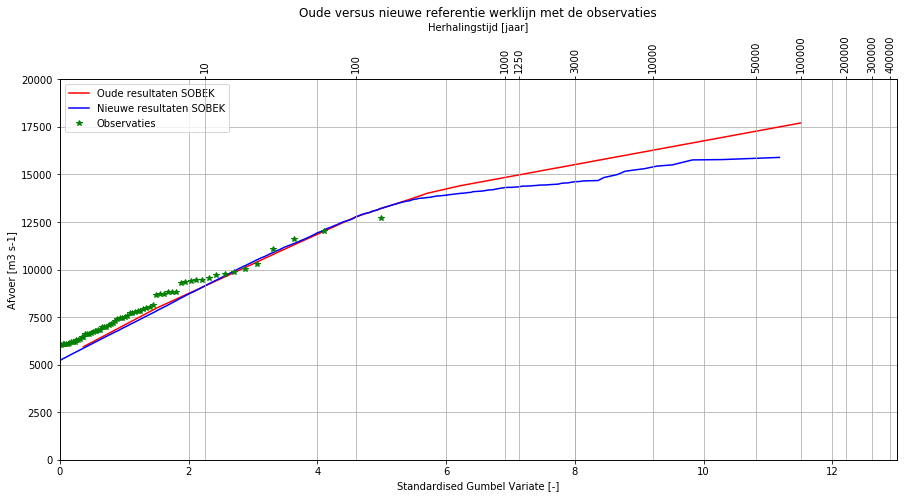

In [10]:
#plot oud versus observations
plt.plot(rijn_old['sgv'],rijn_old['mu'],'r-',label="Oude resultaten SOBEK")
plt.plot(rijn_new['sgv'],regression_2018(rijn_new['mu']),'b-',label="Nieuwe resultaten SOBEK")
plt.plot(rijn_obs['sgv'],rijn_obs['mu'],'g*',label="Observaties")
ax=plt.gca()
xlm = ax.set_xlim(0,13)
fig=plt.gcf()
fig.set_size_inches(15,7)
lgnd = ax.legend(loc="upper left")
ax2 = add_gum_axis(Tretlist,ax)
ti=ax.set_title('Oude versus nieuwe referentie werklijn met de observaties')
ylm = ax.set_ylim(0,20000)

In [11]:
# Hulp routines voor de uitintegratie
def normal_cdf(x,parms):
    mu = parms[0]
    sigma = parms[1]
    return (1.0 + erf((x-mu) / sigma / sqrt(2.0))) / 2.0

def normal_pdf(x,parms):
    mu = parms[0]
    sigma = parms[1]
    return exp(-0.5*((x-mu)/2./sigma)**2)/(sigma*(2*pi)**0.5)

In [12]:
# Voer een uitintegratie uit voor de oude resultaten
nx_old = len(rijn_old['sgv'])
rijn_old['uitintegratie']={}
rijn_parms = {'distpar':[(rijn_old['mu'][i] ,rijn_old['sigma'][i]) for i in range(nx_old)],
              'F':np.exp(-np.exp(-rijn_old['sgv']))}
rijn_old['uitintegratie']['levels'] = np.array(list(range(5000,20000,100)))
rijn_cdf = outintegrate(rijn_parms, rijn_old['uitintegratie']['levels'], normal_cdf)
rijn_old['uitintegratie']['sgv'] = -np.log(-np.log(rijn_cdf))

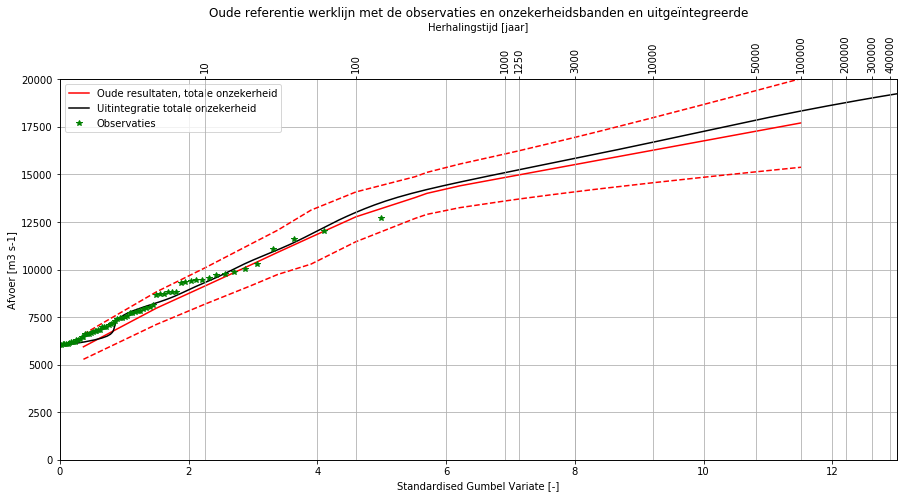

In [13]:
#plot oud versus observations met 
plt.plot(rijn_old['sgv'],rijn_old['mu'],'r-',label="Oude resultaten, totale onzekerheid")
plt.plot(rijn_old['sgv'],rijn_old['mu']+1.96*rijn_old['sigma'],'r--')
plt.plot(rijn_old['sgv'],rijn_old['mu']-1.96*rijn_old['sigma'],'r--')
plt.plot(rijn_old['uitintegratie']['sgv'],rijn_old['uitintegratie']['levels'],'k-',label="Uitintegratie totale onzekerheid")
plt.plot(rijn_obs['sgv'],rijn_obs['mu'],'g*',label="Observaties")

ax=plt.gca()
ax.set_xlim(0,13)
fig=plt.gcf()
fig.set_size_inches(15,7)
lgnd = ax.legend(loc="upper left")
add_gum_axis(Tretlist,ax)
ti=ax.set_title('Oude referentie werklijn met de observaties en onzekerheidsbanden en uitgeïntegreerde')
ylm = ax.set_ylim(0,20000)

In [33]:
# Load ensembles into dictionaries
# Read the file into a dictionary, labelled by event->timeseries
datafile = 'read_Qmax_sums_results.csv'
sep = ';'
with open(datafile,"r") as fnin:
    line = fnin.readline().strip()
    colnames = re.sub(r'[^\x00-\x7F]','', line).split(sep)
    ensembles = { colname:[] for colname in colnames}
    while line:
        line = fnin.readline()
        linesplit = line.strip().split(sep)
        for i in range(len(linesplit)):
            if linesplit[i]:
                try:
                    ensembles[colnames[i]].append(float(linesplit[i].replace(',','.')))
                except:
                    ensembles[colnames[i]].append(linesplit[i])

# Select realizations from ensembles:
first_realization = 0
last_realization = 100
refnr = 113

label2nr = {}
rownames = ensembles['Scenario']
for i in range(len(rownames)):
    label2nr[rownames[i]] = i
selected = ['Sum%d'%dd for dd in range (first_realization,last_realization+1)]    # selected labels for realizations
selnr = [label2nr[rowname] for rowname in selected]

# Determine min, max, alpha, beta for each ensemble
irow_ref = label2nr['Sum%d'%refnr]
a = np.array([])
b = np.array([])
alpha = np.array([])
beta = np.array([])
qref = np.array([])

a_2se = np.array([])
b_2se = np.array([])
alpha_2se = np.array([])
beta_2se = np.array([])
colnames.pop(0)
for icol in range(len(colnames)): 
    sample=np.array([ensembles[colnames[icol]][i] for i in selnr])
    est,var = fb.fitBetaMomentsJack(sample)
    
    alpha = np.append(alpha,est[0])
    beta = np.append(beta,est[1])
    a = np.append(a,est[2])
    b = np.append(b,est[3])
    alpha_2se = np.append(alpha,var[2])
    beta_2se = np.append(beta,var[3])
    a_2se = np.append(a,var[0])
    b_2se = np.append(b,var[1])
    qref = np.append(qref,ensembles[colnames[icol]][irow_ref])
    
sys.stdout.write("%11s    %8s %8s       %8s    %8s    %s\n"%('Ref','alpha','beta','A', 'B', 'Label'))
for i in range(len(qref)):
    sys.stdout.write("%8.5f    %8.5f %8.5f    %8.5f %8.5f    %s\n"%(qref[i],alpha[i],beta[i],a[i],b[i],colnames[i]))    

        Ref       alpha     beta              A           B    Label
17553.90820     3.71201  2.09194    13615.14343 19462.67328    b24000
14902.15723     2.62803  1.50101    13412.81502 15745.20368    maxQ_14199_maxV_28.8_year_3345
15286.16699     1.77462  1.56257    13709.32447 16841.72014    maxQ_14210_maxV_18.1_year_2288
13351.64551     2.03466  1.06650    11795.17034 14115.33281    maxQ_14256_maxV_11.5_year_3236
14307.43555     1.61699  1.45716    12767.70517 15810.41097    maxQ_14434_maxV_14.1_year_3126
14193.20605     1.33763  1.48444    13180.73558 15434.22470    maxQ_14450_maxV_23.4_year_3048
14482.79395     1.45828  1.46577    13095.98703 15817.19115    maxQ_14567_maxV_18.9_year_7445
15096.23535     1.54703  1.60232    13823.27269 16404.51866    maxQ_14594_maxV_23.3_year_9987
14179.44336     1.64708  1.55112    12614.64039 15610.31952    maxQ_14756_maxV_14.5_year_7191
14396.85254     2.01663  2.02840    13369.75899 15641.03664    maxQ_14808_maxV_23.1_year_9093
14611.16504    

In [34]:
# logarithmic fits on the location parameters of the Beta distribution A and B
q0 = 3000
clog_a1 = linfit(qref-q0,np.log(qref-a))
clog_b1 = linfit(qref-q0,np.log(b-qref))

# linear fits on the shape parameters alpha and beta
c_alpha1 = linfit(qref,alpha)
c_beta1 = linfit(qref,beta)

In [15]:
# os.system('RUN002_LHSsampling.tek')    # open file met LHC parameters in standaard editor
# res = os.system(os.environ['EDITOR']+' read_Qmax_sums_results.csv')
# res = os.system('wvi read_Qmax_sums_results.csv')

In [16]:
# Lees TEKAL file met Latin Hyper Cube parameter sets
LHCSets = readTEKAL('RUN002_LHSsampling.tek','XLHS')

In [17]:
# Least-squares line fit
def linfit(x,y):
    nn = ma.count(x)
    c = [(ma.sum(x*y)-ma.sum(x)*ma.sum(y)/nn)/(ma.sum(x*x)-ma.sum(x)*ma.sum(x)/nn)]
    c.append((ma.sum(y)-c[0]*ma.sum(x))/nn)
    return(c)

In [18]:
# os.system('RUN002_LHSsampling.tek')    # edit tek file
# Data Block with the XLHS-values.
# Legend for the 11 columns:
# Column   1: X-value for stochastic variable Nr.   1/11, with name Friction        , and distribution Parabolic   
# Column   2: X-value for stochastic variable Nr.   2/11, with name DijkhTypeA      , and distribution Parabolic   
# Column   3: X-value for stochastic variable Nr.   3/11, with name DijkhTypeB-DEM  , and distribution Parabolic   
# Column   4: X-value for stochastic variable Nr.   4/11, with name DijkhTypeB-KRUIN, and distribution Parabolic   
# Column   5: X-value for stochastic variable Nr.   5/11, with name DijkhTypeC      , and distribution Parabolic   
# Column   6: X-value for stochastic variable Nr.   6/11, with name DoorbraakLoc07  , and distribution nExponential
# Column   7: X-value for stochastic variable Nr.   7/11, with name DoorbraakLoc08  , and distribution nExponential
# Column   8: X-value for stochastic variable Nr.   8/11, with name DoorbraakLoc09  , and distribution nExponential
# Column   9: X-value for stochastic variable Nr.   9/11, with name MySwitch07      , and distribution Binary      
# Column  10: X-value for stochastic variable Nr.  10/11, with name MySwitch08      , and distribution Binary      
# Column  11: X-value for stochastic variable Nr.  11/11, with name MySwitch09      , and distribution Binary      
#
#Column 1             2             3             4             5             6             7             8             9            10            11

# Bepaal voor elk ensemble de door de ruwheidscoefficient verklaarde variantie.
# Elk ensemble staat voor één event, doorgerekend met verschillende parameterset (elk met eigen ruwheidscoefficient)
sigma_fric = {}
sigma_fric_perc = np.array([])
std_r = np.std(LHCSets[0])
for eventkey, eventdata in ensembles.items():
    try:
        a,b = linfit(LHCSets[0],eventdata[first_realization:last_realization+1])
        std_q = np.std(eventdata[first_realization:last_realization+1])
        sigma_fric_perc = np.append(sigma_fric_perc,abs(a)*std_r/std_q*100.)
        sigma_fric[eventkey]={'slope':a,'std_r':std_r,'std_q':std_q,'ratio':sigma_fric_perc[-1]}
    except:
        pass
    
#sigma_fric_perc is het procentuele aandeel van de frictie (kolom 1) in de spreiding voor elk event

In [19]:
# Interpoleer de procentuele bijdrage van de frictie naar qref
sigma_fric_perc_qref = []
for i in tqdm(list(range(np_qref.size))):
    sigma_fric_perc_qref.append(interpolate(qref,sigma_fric_perc,np_qref[i]))
np_sigma_fric_perc_qref = np.array(sigma_fric_perc_qref)

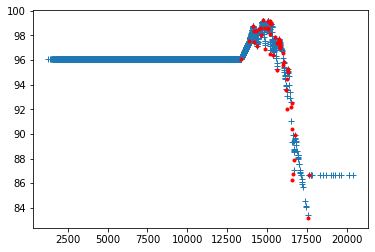

In [20]:
plt.plot(np_qref,sigma_fric_perc_qref,'+')
plt.plot(qref,sigma_fric_perc,'r.')

C:\Users\leander\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


$$
A(q_r)\,=\,q_r\,-\,C_{A1}\exp\left(C_{A2}(q_r-q_0)\right)\\ \,\\ 
B(q_r)\,=\,q_r\,+\,C_{B1}\exp\left(C_{B2}(q_r-q_0)\right)\\ \,\\
\alpha(q_r)\,=\,\max\left(1,C_{\alpha 1}\,+\,C_{\alpha 2}q_r\right)\\ \,\\
\beta(q_r)\,=\,\max\left(1,C_{\beta 1}\,+\,C_{\beta 2}q_r\right) 
$$

In [32]:
a

-10407.294469738885

In [ ]:
plt.plot(qref,a,'bo',label='A-parameter, lower extent')
fig = plt.gcf()
ax=plt.gca()
ax.set_ylim([10000,21000])
ax.plot(qref,b,'ro',label='B-parameter, upper extent')
ax.plot(qref,qref,'g--',label='Reference discharge')
ax.set_xlim([10000,21000])

#logarithmic fits
qs=np.array(list(range(3000,18000,100)))
ax.plot(qs,qs-np.exp(clog_a1[0]*(qs-q0)+clog_a1[1]),'b.-',label="Q-%.3f * exp(%.3e*(Q - %.0f))"%(np.exp(clog_a1[1]),clog_a1[0],q0))
ax.plot(qs,qs+np.exp(clog_b1[0]*(qs-q0)+clog_b1[1]),'r.-',label="Q+%.3f * exp(%.3e*(Q - %.0f))"%(np.exp(clog_b1[1]),clog_b1[0],q0))

fig.set_size_inches(13,9)
ax.set_xlabel('Reference discharge [m3 s-1]')
ax.set_ylabel('A, B, Ref [m3 s-1]')
ax.set_title('Extents A and B of the fit 4-parameter Beta distribution')
lgnd = ax.legend()

In [ ]:
# Combi meteo (normaal) en hydraulische onzekerheid (beta-verdeling) door samplen en opnieuw Beta fitten
# q_Meteo gesampled uit de bovenstaande onzwekerheidsband voor de meteo
# q_Hydraulica gesampled uit een beta-verdeling met verwachting 0
# gesommeerd
# Beta verdeling gefit

def CombiNormalAndBeta(betaparameters,normalparameters,nx):
    alpha = betaparameters[0]
    beta = betaparameters[1]
    AA = betaparameters[2]
    BB = betaparameters[3]
#   DD = sigma0*(alpha+beta)*((alpha+beta+1)/(alpha*beta))**0.5     # DD for s given sigma
    DD = BB - AA                                                    # Keep the same interval
    AA = -alpha*DD/(alpha+beta)                                     # Zero mean
    BB = beta*DD/(alpha+beta)
    
    mu = normalparameters[0]
    sigma = normalparameters[1]

    betas=np.random.beta(alpha,beta,nx)*DD+AA
    normals=np.random.normal(mu,sigma,nx)
    sums=betas+normals
    est2 = fb.fitBetaQuantiles(sums)
    return est2

In [ ]:
from ipywidgets import *
sample_size = 10000
mu=rijn_new['mu']
sgv=rijn_new['sgv']
sgm=rijn_new['sigma']

def effective_beta_quantiles(stdgumvar, sample_size):
    qhbv = interpolate(sgv,mu,stdgumvar)                   
    sigma = interpolate(sgv,sgm,stdgumvar)                           # sigma jackknife/hydrology(HBV)
    F, normals = quantilesetnormal(sample_size,qhbv,sigma)    
    hydrologic_uncertainty=regression_2018(normals)
    
    qsbk = regression_2018([qhbv])[0]
    alpha = max(1.0,c_alpha1[0]*qsbk+c_alpha1[1]) 
    beta = max(1.0,c_beta1[0]*qsbk+c_beta1[1])
    AA = qsbk-np.exp(clog_a1[0]*(qsbk-q0)+clog_a1[1])
    BB = qsbk+np.exp(clog_b1[0]*(qsbk-q0)+clog_b1[1])
    DD = BB - AA                                                    # Keep the same interval
    mean = alpha/(alpha+beta)*DD+AA
    BB = BB - mean
    AA = AA - mean
    F, betas = quantilesetbeta(sample_size,alpha,beta,AA,BB)    
    hydraulic_uncertainty=betas

    sumlist = []
    for h1 in hydrologic_uncertainty:
        for h2 in hydraulic_uncertainty:
            sumlist.append(h1+h2)
    sums=np.array(sumlist)
    est2 = fb.fitBetaQuantiles(sums)
    beta_parameters = (alpha,beta,AA,BB)
    normal_parameters = (qhbv,sigma)
    return (est2, sums, beta_parameters, normal_parameters)

def effective_beta_random(stdgumvar, sample_size):
    qhbv = interpolate(sgv,mu,stdgumvar)
    sigma = interpolate(sgv,sgm,stdgumvar)
    normals = np.random.normal(qhbv,sigma,sample_size)     # trek een normaal verdeelde met mu=qref en sigma(qref)
    hydrologic_uncertainty=regression_2018(normals)         # haal deze door de HBV->SOBEK regressie

    qsbk = regression_2018([qhbv])[0]
    alpha = max(1.0,c_alpha1[0]*qsbk+c_alpha1[1]) 
    beta = max(1.0,c_beta1[0]*qsbk+c_beta1[1])
    AA = qsbk-np.exp(clog_a1[0]*(qsbk-q0)+clog_a1[1])
    BB = qsbk+np.exp(clog_b1[0]*(qsbk-q0)+clog_b1[1])
    DD = BB - AA                                                    # Keep the same interval
    mean = alpha/(alpha+beta)*DD+AA
    BB = BB - mean
    AA = AA - mean
    hydraulic_uncertainty=np.random.beta(alpha,beta,sample_size)*DD+AA # trek een Beta verdeelde 
    sums=hydrologic_uncertainty
    # sums=hydraulic_uncertainty+hydrologic_uncertainty
    est2 = fb.fitBetaQuantiles(sums)
    beta_parameters = (alpha,beta,AA,BB)
    normal_parameters = (qhbv,sigma)
    return (est2, sums, beta_parameters, normal_parameters)

In [ ]:
#  recalc_beta = True: Bereken Beta parameters langs de gumbel-as  door willekeurige trekkingen te fitten
#  recalc_beta = False: Haal voorberekende resultaten van een file (berekening duurt erg lang)
recalc_beta = False
size = 50000
estimates = []
if recalc_beta:
    with open('effective_beta.txt','w') as effbeta:
        for sgvval in np.array(list(range(-4,23)))*0.5:
            result=effective_beta_random(sgvval, size)        
            est2=result[0]
            estimates.append((sgvval,est2))
            effbeta.write("%15.5e, %15.5e, %15.5e, %15.5e, %15.5e\n"%(sgvval, est2[0], est2[1], est2[2], est2[3]))
else:
    if os.path.isfile('effective_beta.txt'):
        with open('effective_beta.txt','r') as effbeta:
            while True:
                l = effbeta.readline()
                if not l:
                    break
                floats = [float(lsub) for lsub in l.split(',')]
                est2 = np.array(floats[1:5])
                sgvval = floats[0]
                estimates.append((sgvval,est2))
                sys.stdout.write("%15.5e, %15.5e, %15.5e, %15.5e, %15.5e\n"%(sgvval, est2[0], est2[1], est2[2], est2[3]))


In [ ]:
# Uitsplitsen varianties, isoleren van de onzekerheid tgv de frictie uit de totale uiteindelijke onzekerheid:
# Cell niet uitvoeren: nog Werk in Uitvoering .....
sigma = interpolate(sgv,sgm,stdgumvar)  # hydrology
qhbv = interpolate(sgv,mu,stdgumvar)

    qsbk = regression_2018([qhbv])[0]
    alpha = max(1.0,c_alpha1[0]*qsbk+c_alpha1[1]) 
    beta = max(1.0,c_beta1[0]*qsbk+c_beta1[1])
    AA = qsbk-np.exp(clog_a1[0]*(qsbk-q0)+clog_a1[1])
    BB = qsbk+np.exp(clog_b1[0]*(qsbk-q0)+clog_b1[1])

for est in estimates:
    yy.append(est[0])       # standardized gumbel variate
    alpha_fit=est[1][0]     # resultante Beta parameters
    beta_fit=est[1][1]
    AA_fit=est[1][2]
    BB_fit=est[1][3]
    mean_t, var_t, skew_t, kurt_t = fb.BetaMoments(alpha_fit,beta_fit,AA_fit,BB_fit)    # moments based on the resultant Beta distribution
    qhbv = interpolate(sgv,mu,yy)                                               # HBV afvoer voor gumbel variaat yy
    qsbk = regression_2018([qhbv])[0]                                           # SOBEK discharge voor gumbel variaat yy
    alpha_hyd = max(1.0,c_alpha1[0]*qsbk+c_alpha1[1])                           # Beta parameters gerelateerd aan hydraulische onzekerheden
    beta_hyd = max(1.0,c_beta1[0]*qsbk+c_beta1[1])
    AA_hyd = qsbk-np.exp(clog_a1[0]*(qsbk-q0)+clog_a1[1])
    BB_hyd = qsbk+np.exp(clog_b1[0]*(qsbk-q0)+clog_b1[1])
    mean_h, var_h, skew_h, kurt_h = fb.BetaMoments(alpha_hyd,beta_hyd,AA_hyd,BB_hyd)    # Momenten uit de Beta parameters tgv hydraulische onzekerheden
    var_m = (interpolate(sgv,sgm,yy))**2.                                       # variantie tgv meteorologische onzekerheid
    var_t2 = var_m + var_h                                                      # totale variantie, moet gelijk zijn aan var_t2


In [ ]:
# Leid verwachting, variantie, scheefheid, kurtosis en het tweezijdig 95% betrouwbaarheidsinterval af uit de beta parameters
yy = []
pct_025 = []
pct_975 = []
pct_500 = []
meanlist = []
varlist = []
skewlist = []
kurtlist = []

for est in estimates:
    yy.append(est[0])
    alpha_fit=est[1][0]
    beta_fit=est[1][1]
    AA_fit=est[1][2]
    BB_fit=est[1][3]
    pct_025.append(fb.beta_reverse(alpha_fit,beta_fit,AA_fit,BB_fit,0.025))
    pct_500.append(fb.beta_reverse(alpha_fit,beta_fit,AA_fit,BB_fit,0.500))
    pct_975.append(fb.beta_reverse(alpha_fit,beta_fit,AA_fit,BB_fit,0.975))
    mean, var, skew, kurt = fb.BetaMoments(alpha_fit,beta_fit,AA_fit,BB_fit)
    meanlist.append(mean)
    varlist.append(var)
    skewlist.append(skew)
    kurtlist.append(kurt)
np_yy = np.array(yy)
np_pct025 = np.array(pct_025)
np_pct500 = np.array(pct_500)
np_pct975 = np.array(pct_975)
np_mean = np.array(meanlist)
np_var = np.array(varlist)
np_skew = np.array(skewlist)
np_kurt = np.array(kurtlist)

In [ ]:
# Voer een uitintegratie uit voor de nieuwe resultaten
def cdfbeta(y,parms):
    return fb.beta_forward(parms[0],parms[1],parms[2],parms[3],y)

rijn_new['uitintegratie'] = {}
np_yy = np.array([est[0] for est in estimates])
rijn_parms_new = {'distpar' : [est[1] for est in estimates],
                  'F' : np.exp(-np.exp(-np_yy))}
rijn_new['uitintegratie']['levels'] = np.array(list(range(6000,21000,100)))
rijn_cdf_new = outintegrate(rijn_parms_new, rijn_new['uitintegratie']['levels'] , cdfbeta)
rijn_new['uitintegratie']['sgv'] = -np.log(-np.log(rijn_cdf_new))

In [ ]:
#plot nieuw versus observations met 
plt.plot(rijn_obs['sgv'],rijn_obs['mu'],'g*',label="Observaties")
plt.plot(np_yy,np_mean,'m-',label='Nieuwe resultaten, meteo+hydraulische onzekerheid')
plt.plot(np_yy,np_pct025,'m--')
plt.plot(np_yy,np_pct975,'m--')
plt.plot(rijn_new['uitintegratie']['sgv'],rijn_new['uitintegratie']['levels'],'k-',label="Uitintegratie")

ax = plt.gca()
ax.set_xlim(0,13)
fig = plt.gcf()
fig.set_size_inches(15,7)
lgnd = ax.legend(loc="upper left")
add_gum_axis(Tretlist,ax)
ti = ax.set_title('Nieuwe referentie werklijn met de observaties en onzekerheidsbanden en uitgeïntegreerde')
ylim = ax.set_ylim(0,20000)

In [ ]:
#plot oud en nieuw uitgeïntegreerd versus observations
plt.plot(rijn_old['uitintegratie']['sgv'],rijn_old['uitintegratie']['levels'],'r-',label="Uitintegratie oud")
plt.plot(rijn_new['uitintegratie']['sgv'],rijn_new['uitintegratie']['levels'],'b-',label="Uitintegratie nieuw")
plt.plot(rijn_obs['sgv'],rijn_obs['mu'],'g*',label="Observaties")

ax=plt.gca()
ax.set_xlim(0,13)
fig=plt.gcf()
fig.set_size_inches(15,7)
lgnd = ax.legend(loc="upper left")
add_gum_axis(Tretlist,ax)
ti=ax.set_title('Oude versus nieuwe uitgeïntegreerde werklijn')
ylm = ax.set_ylim(0,20000)

In [ ]:
#fit een functioneel voorschrift uit de berekende punten op de manier van Henk vd Boogaerd
plt.plot(rijn_new['uitintegratie']['sgv'],rijn_new['uitintegratie']['levels'],'b*',label="Uitintegratie nieuw")
plt.plot(rijn_obs['sgv'],rijn_obs['mu'],'g*',label="Observaties")

ax=plt.gca()
ax.set_xlim(0,13)
fig=plt.gcf()
fig.set_size_inches(15,7)
lgnd = ax.legend(loc="upper left")
add_gum_axis(Tretlist,ax)
ti=ax.set_title('Oude versus nieuwe uitgeïntegreerde werklijn')
ylm = ax.set_ylim(0,20000)

# plot a piece-wise linear
x = [0,   4.7,  8,    12,   20     ]
y = [5250,13500,14800,17400,17400  ]
plt.plot(x,y,'r-+')

<H2> Gedeeltelijk lineaire benadering met exponentiële overgangen</H2>
Dit is een generalisatie van de uitdrukking die Henk vd Boogaard gebruikt voor <tt>regressie_2018</tt>, namelijk:
$$
y(x)\,=\,
C\,+r_1 x
+ \sum\limits_{i=2}^n \left(r_i-r_{i-1}\right)\,\log\left(1\,+\,\exp\left(\frac{x-\mu_{i-1}}{\sigma_{i-1}}\right)\right)\,\,,
$$
geïmplementeerd in de onderstaande functie <tt>pwlin</tt>.
De knikpunten (op de horizontale as) bevinden zichop de $\mu_i$, de helling van de stukken is voorgeschreven door de $r_i$ op het interval $\left(\mu_{i-1},\mu_i\right)$, $C$ is een offset en de $\sigma_i$ bepaalt de scherpte van het knikpunt bij $\mu_i$, m.a.w. hoe glad de overgang verloopt. Zo kan in termen van een beperkte set parameters bovenstaande curve redelijk beschreven worden. Er zijn grofweg vier intervallen te onderscheiden, dus vier hellingen en drie knikpunten.

Gegeven een set knikpunten $\left(x_i,y_i\right)$, kan bepaald worden:
<ul>
    <li>$r_i=\left(y_i-y_{i-1}\right)/\left(x_i-x_{i-1}\right)$</li>
    <li>$\mu_i=r_i$</li>
    <li>$C=y_1-r_1x_1$</li>
</ul>
De $\sigma_i$ moeten nog naar smaak gekozen worden en hangen samen met hoe dicht het knikpunt benaderd moet worden.
Omdat de knikpunten zelf geen onderdeel van de data zijn en ook omdat de curve een beetje glad moet blijven, hoeven de $\sigma_i$ in dit geval niet heel klein te zijn.
Dit is geïmplementeerd in de onderstaande functie <tt>pwlin_points</tt>. Dan zijn er dus 5 punten nodig in dit geval.

In [ ]:
#Piecewise linear with exonential smooth transitions
#Dit is de aanpak van Henk vd Boogaard, maar dan generieker:

MAX_EXP = 700.     # max argument of the exponent function
def pwlin(x,r,mu,sigma):
    x_ = []
    for value in x:
        y = r[0] + r[1]*value
        for i in range(1,len(mu)):
            z = (value-mu[i])/sigma[i]
            if (z<=MAX_EXP):
                a = np.log(1+np.exp(z))
            else:
                a = z
            y += (r[i+1]-r[i])*sigma[i]*a
        x_.append(y)
    return x_

def pwlin_points(x,xs,ys,sigma):
    r=np.array([ys[0] - ((ys[1]-ys[0])/(xs[1]-xs[0]))*xs[0]])
    for i in range(1,len(xs)):
        r = np.append(r, (ys[i]-ys[i-1])/(xs[i]-xs[i-1]))
    print (r)
    return pwlin(x,r,xs[:-1],sigma)    

In [ ]:
def benadering(sgv):
    xss = np.array([0,   4.7,  8,    12.0,   20 ])
    yss = np.array([5250,13500,14800, 17300, 17400])
    sgm = np.array([np.nan,0.3,0.1,0.5,0.1])
    return pwlin_points(sgv,xss,yss,sgm)

#fit een functioneel voorschrift uit de berekende punten op de manier van Henk vd Boogaerd
plt.plot(rijn_new['uitintegratie']['sgv'],rijn_new['uitintegratie']['levels'],'b*',label="Uitintegratie nieuw")
plt.plot(rijn_obs['sgv'],rijn_obs['mu'],'g*',label="Observaties")

ax=plt.gca()
ax.set_xlim(0,13)
fig=plt.gcf()
fig.set_size_inches(15,7)
lgnd = ax.legend(loc="upper left")
add_gum_axis(Tretlist,ax)
ti=ax.set_title('Oude versus nieuwe uitgeïntegreerde werklijn')
ylm = ax.set_ylim(0,20000)

# plot benadering
sgv = np.linspace(0, 13, num=200)
qq = benadering(sgv)
plt.plot(sgv,qq,'r-')

De totale uitdrukking wordt nu:
$$Q(y)\,=\,C\,+\,r_1 y\,+\,(r_2-r_1)\,\sigma_1\log\left(1+\exp\left(\frac{y-\mu_1}{\sigma_1}\right)\right)+\,(r_3-r_2)\,\sigma_2\log\left(1+\exp\left(\frac{y-\mu_2}{\sigma_2}\right)\right)$$
$$\phantom{Q(y)\,=\,C\,+\,r_1 y\,}+\,(r_4-r_3)\,\sigma_3\log\left(1+\exp\left(\frac{y-\mu_3}{\sigma_3}\right)\right)+\,(r_5-r_4)\,\sigma_4\log\left(1+\exp\left(\frac{y-\mu_4}{\sigma_4}\right)\right)$$

<table>
<tr>    
    <td>
$C = 5250.0$ <br>
$r_1 = 1755.3$ <br>
$r_2 = 393.9$  <br>
$r_3 = 625.0$<br>
$r_4 = 12.5$<br>
$r_5 = 0.0$<br>
    </td>
<td>
$\mu_1 = 0.0$ <br>
$\mu_1 = 4.7$ <br>
$\mu_2 = 8.0$  <br>
$\mu_3 = 12.0$<br>
    </td>
</tr>
Met $y$ de standardised gumbel variate, uitgedrukt in de herhalingstijd $T_r$ als:
$$
y\,=\,-\log\left(-\log\left(1-\frac 1 {T_r}\right)\right)
$$

In [ ]:
import math   # Crucial import !!!
def werklijn functie(x, fit_regr=False):
    c      = 342.254390
    r1     = 0.91577902
    mu1    = 14442.2780 #ORIG
    sigma1 = 307.118620
    r2     = 0.32752076
    mu2    = 18573.2200 #ORIG
    sigma2 = 2.71804449E-14
    r3     = 0.53632634 #ORIG
    mu3    = 21904.1250 #ORIG
    sigma3 = 136.807970  
    r4     = 0.21296795
    mu4    = 26177.6500 #ORIG
    sigma4 = 79.5476640
    r5     = 0.00000000
    if fit_regr == True:
        mu1    = 14800.0000
        mu2    = 17750.0000
        r3     = 0.75000000
        mu3    = 20000.0000
    
    x_ = []
    for value in x:
        z1 = (value-mu1)/sigma1
        z2 = (value-mu2)/sigma2
        z3 = (value-mu3)/sigma3
        z4 = (value-mu4)/sigma4
        
        a1 = (r1*value)
        a2 = ((r2-r1)*sigma1*np.log(1+np.exp(z1)))
        try:
            a3 = ((r3-r2)*sigma2*np.log(1+math.exp(z2)))
        except:
            a3 = ((r3-r2)*sigma2*z2)
        a4 = ((r4-r3)*sigma3*np.log(1+np.exp(z3)))
        a5 = ((r5-r4)*sigma4*np.log(1+np.exp(z4)))
        
        y = c + a1 + a2 + a3 + a4 + a5
        x_.append(y)

    return x_


# Genereer een tabel voor gezette herhalingstijden
table = {'Herhaaltijd':Tretlist}
qmax_old = []
sigma_old = []
uit_old = []
qmax_new = []
sigma_new = []
uit_new = [] 
table={'Herhaaltijd':Tretlist}
for tr in Tretlist:
    qmax_old.append(interpolate(rijn_old['sgv'],rijn_old['mu'],-np.log(-np.log(1.-1./tr)),default=np.nan))
    sigma_old.append(interpolate(rijn_old['sgv'],rijn_old['sigma'],-np.log(-np.log(1.-1./tr)),default=np.nan))
    uit_old.append(interpolate(rijn_old['uitintegratie']['sgv'],rijn_old['uitintegratie']['levels'],-np.log(-np.log(1.-1./tr)),default=np.nan))
    qmax_new.append(interpolate(rijn_new['sgv'],rijn_new['mu'],-np.log(-np.log(1.-1./tr)),default=np.nan))
    sigma_new.append(interpolate(rijn_new['sgv'],rijn_new['sigma'],-np.log(-np.log(1.-1./tr)),default=np.nan))
    uit_new.append(interpolate(rijn_new['uitintegratie']['sgv'],rijn_new['uitintegratie']['levels'],-np.log(-np.log(1.-1./tr)),default=np.nan))
table['Qmax oud']=qmax_old
table['Sigma oud']=sigma_old
table['Uitgeïntegreerd oud']=np.round(np.array(uit_old)*100)/100.
table['Qmax nieuw']=np.round(np.array(qmax_new)*100)/100.
table['Sigma nieuw']=sigma_new
table['Uitgeïntegreerd nieuw']=np.round(np.array(uit_new)*100)/100.
pd.DataFrame(table)


<H2>Relatieve bijdrage van de ruwheid aan de totale onzekerheid</H2>
De totale variantie is als volgt opgebouwd:
$$
\sigma^2_{totaal}
\,=\,
\sigma^2_{jac
$$

In [ ]:
# Multiple regressie (Least-Squares sense)
def linearfit(y,x):
    # fits the linear expression y[j] = sum(alpha[i]*x[ij]) + B
    # y is a numpy array size [nsample]
    # x is a numpy array size [nsample, nvar]
    ns = np.shape(y)[0]
    nv = np.shape(x)[1]
    A = np.zeros([nv+1,nv+1])
    B = np.zeros([nv+1])
    for j in range(ns):
        for i in range(nv):
            for k in range(i,nv):
                A[i,k] += x[j,i]*x[j,k]
            A[i,nv] += x[j,i]
            B[i] += y[j]*x[j,i]
        A[nv,nv] += 1.
        B[nv] += y[j]
    for k in range(1,nv+1):
        for i in range(k):
            A[k,i] = A[i,k]
    alphas = np.linalg.solve(A, B)
    return (alphas[:nv],alphas[nv])